# 🧠 Entrenamiento de Modelos Clásicos de Machine Learning

Este notebook entrena y compara modelos clásicos (SVM, Random Forest, KNN y MLP)  
utilizando las características de color y textura extraídas de las imágenes de hojas de papa.  
El objetivo es determinar qué modelo ofrece el mejor rendimiento en clasificación.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## 📂 1. Carga del dataset

Se carga el CSV generado en el notebook anterior con las características de las imágenes.  
Luego se inspeccionan las dimensiones y una muestra de los datos.


In [2]:
# Ruta del dataset con las características extraídas
data_path = "../data/3_data_extract_features/features_dataset.csv"

df = pd.read_csv(data_path)
print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (3076, 11)


,mean_R,mean_G,mean_B,std_R,std_G,std_B,contrast,homogeneity,energy,entropy,label
0,128.616251,139.298928,128.693559,53.584559,47.329740,67.281873,156.163657,0.202887,0.017634,12.319971,Bacteria
1,120.013433,129.300203,70.988461,41.580883,40.368936,52.271149,520.175789,0.093870,0.012094,13.357643,Bacteria
2,141.421616,144.346261,130.426778,39.643502,36.942884,54.940789,468.388373,0.158820,0.021977,12.430230,Bacteria
3,111.892459,110.107422,80.595265,50.574446,51.036134,57.771348,796.226517,0.072948,0.009259,13.958764,Bacteria
4,121.738301,127.139848,85.049904,50.031091,51.864478,55.379393,366.683176,0.159419,0.015661,12.967569,Bacteria


## 🧮 2. Preparación de datos

En este paso:
- Se separan las características (X) de las etiquetas (y).  
- Se codifican las clases con `LabelEncoder`.  
- Se escalan los datos con `StandardScaler`.  
- Se dividen los datos en conjuntos de entrenamiento y prueba (80/20).


In [3]:
# Separar características y etiquetas
X = df.drop("label", axis=1)
y = df["label"]

# Codificación de etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")
print("Clases:", list(encoder.classes_))


Entrenamiento: (2460, 10), Prueba: (616, 10)
Clases: ['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


## ⚙️ 3. Definición de modelos clásicos

Se definen los clasificadores clásicos que se entrenarán y compararán:
- SVM
- Random Forest
- KNN
- MLP (red neuronal multicapa)


In [4]:
models = {
    "SVM": SVC(kernel="rbf", C=1.0, gamma="scale"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", max_iter=300, random_state=42)
}


## 🚀 4. Entrenamiento y evaluación de modelos

Cada modelo se entrena con los datos de entrenamiento y se evalúa con el conjunto de prueba.  
Se calcula la exactitud (`accuracy`) y se muestra un reporte de clasificación detallado.

In [5]:
results = []

for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results.append({"Modelo": name, "Accuracy": acc})
    
    print(f"🔹 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))
    print("-" * 60)

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
results_df



Entrenando modelo: SVM
🔹 SVM Accuracy: 0.4708
              precision    recall  f1-score   support

    Bacteria       0.60      0.68      0.63       114
       Fungi       0.38      0.55      0.45       150
     Healthy       1.00      0.10      0.18        40
    Nematode       1.00      0.36      0.53        14
        Pest       0.43      0.35      0.39       122
 Phytopthora       0.40      0.28      0.33        69
       Virus       0.52      0.55      0.54       107

    accuracy                           0.47       616
   macro avg       0.62      0.41      0.43       616
weighted avg       0.51      0.47      0.46       616

------------------------------------------------------------

Entrenando modelo: Random Forest
🔹 Random Forest Accuracy: 0.4935
              precision    recall  f1-score   support

    Bacteria       0.56      0.68      0.61       114
       Fungi       0.40      0.55      0.47       150
     Healthy       0.71      0.12      0.21        40
    Nematod

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Modelo,Accuracy
3,MLP,0.509740
1,Random Forest,0.493506
2,KNN,0.478896
0,SVM,0.470779


## 📊 5. Matriz de confusión del mejor modelo

Se visualiza la matriz de confusión del modelo con mejor rendimiento.


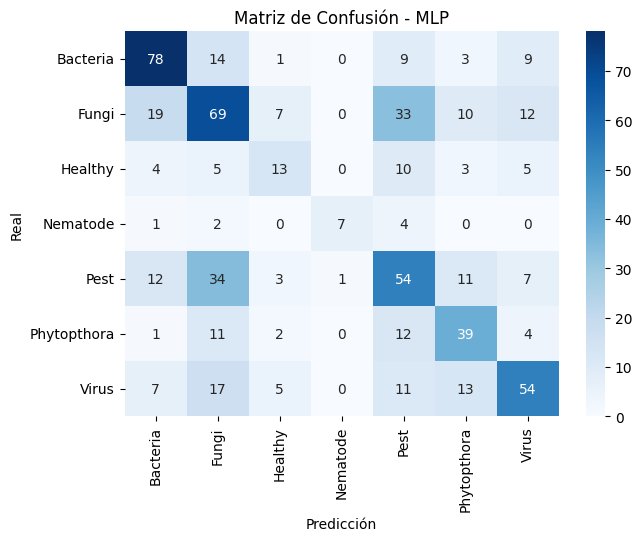

In [6]:
best_model_name = results_df.iloc[0]["Modelo"]
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title(f"Matriz de Confusión - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## 💾 6. Guardado del mejor modelo y objetos auxiliares

Se guarda el modelo con mejor desempeño junto al `LabelEncoder` y el `Scaler`  
para su uso posterior en la clasificación de nuevas imágenes.


In [7]:
import joblib

save_dir = "../models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_model, f"{save_dir}/best_model.pkl")
joblib.dump(encoder, f"{save_dir}/label_encoder.pkl")
joblib.dump(scaler, f"{save_dir}/scaler.pkl")

print(f"Modelo '{best_model_name}' guardado correctamente en {save_dir}/")


Modelo 'MLP' guardado correctamente en ../models/


## 📈 7. Comparación visual de modelos

Se muestra un gráfico de barras con la exactitud (`accuracy`) de cada modelo.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_7324\153339137.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Modelo", y="Accuracy", palette="viridis")


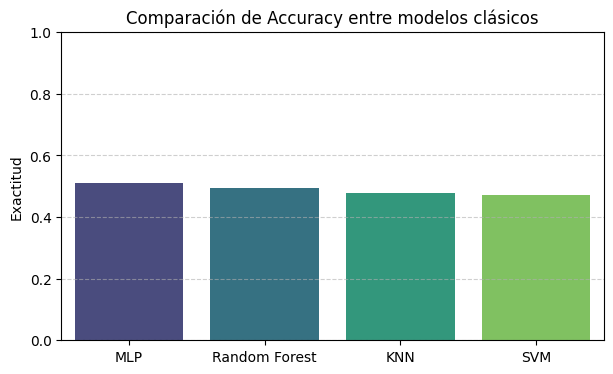

In [8]:
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x="Modelo", y="Accuracy", palette="viridis")
plt.title("Comparación de Accuracy entre modelos clásicos")
plt.ylabel("Exactitud")
plt.xlabel("")
plt.ylim(0,1)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()
